In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)
!gdown --id 1OlOm1jEcCFz_HkHDsqhzyoH6NNt_WAG9

Mounted at /content/gdrive/
Downloading...
From: https://drive.google.com/uc?id=1OlOm1jEcCFz_HkHDsqhzyoH6NNt_WAG9
To: /content/bank-additional-full.csv
5.83MB [00:00, 18.6MB/s]


# Dependencies

In [ ]:
!pip install category_encoders
!pip install umap-learn

     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 81kB 5.4MB/s 
     |████████████████████████████████| 1.1MB 28.3MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=f1a87015cb9ac7cec2c0dd138bd16584f1450733e9cdfbf754550893ba518e9e
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel for pynndescent: filename=pynndescent-0.5.4-cp37-none-any.whl size=52374 sha256=abf8eb0daf1566cf82b2ed49d16ca11dcd10aea6a81277a96e46b121e5067839
  Stored in directory: /root/.cache/pip/wheels/42/4b/8c/f6f119c67cf6583bb192431fa8f7278cf95e5b943055077d94
Successfully built umap-learn pynndescent


In [ ]:
import numpy as np
import scipy
import pandas as pd
from scipy import stats
from scipy.stats import norm

from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imb_make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.decomposition import PCA, TruncatedSVD, NMF
from sklearn.manifold import TSNE
from sklearn.impute import KNNImputer

from category_encoders.target_encoder import TargetEncoder
import umap

from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
set_matplotlib_formats('png') # svg

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Functions

In [ ]:
def func_roc_auc(proba, y):
    """just for fun"""
    sns.set(style="whitegrid", palette='Dark2')
    
    auc = roc_auc_score(np.array(y), np.transpose(proba)[1])
    print(f'Лучшее качество auc_best_estimator: {auc:.3}')
    
    fpr, tpr, _ = roc_curve(y, proba[:,1])
    
    f = plt.figure()
    plt.plot(fpr, tpr, label = 'best_estimator')
    plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc = "lower right")
    plt.show()

In [ ]:
def matthews_cc(contingency_table):
    
    a_1 = contingency_table.iloc[0,0]
    b_2 = contingency_table.iloc[0,1]
    c_3 = contingency_table.iloc[1,0]
    d_4 = contingency_table.iloc[1,1]
    n = contingency_table.sum().sum()
    
    if n <= 40:
        return print('not enough observations')    
    
    con_1 = ((a_1 + c_3) * (a_1 + b_2)) / n
    con_2 = ((a_1 + c_3) * (c_3 + d_4)) / n
    con_3 = ((b_2 + d_4) * (a_1 + b_2)) / n
    con_4 = ((b_2 + d_4) * (c_3 + d_4)) / n
    
    if (con_1 or con_2 or con_3 or con_4) < 5:
        return print('wrong density of distribution')
    
    cont = stats.chi2_contingency(contingency_table)
    # считаем кооэффициент корреляции
    MCC = (a_1 * d_4 - b_2 * c_3) / (np.sqrt((a_1 + b_2) * (a_1 + c_3) * (b_2 + d_4) * (c_3 + d_4)))
    # считаем статистику
    Chi_square = n * (MCC ** 2) 
    # считаем p-value для коэффициента
    p_value = 1 - stats.chi2.cdf(Chi_square, df = 1)
    #'cont =', cont, '\n',
    return print( 'MCC =', MCC, '\n', 'Chi_square =', Chi_square, '\n', 'p_value =', p_value)

In [ ]:
def plot_func(data, column_x, column_y, figsize=None):
    sns.set(font_scale=1.2, style="whitegrid")  
    if figsize is not None:
        fig, axes = plt.subplots(1,2,figsize=figsize)
    else:
        fig, axes = plt.subplots(1,2,figsize=(20,5))
    data.loc[:, column_x].value_counts().plot.bar(ax=axes[0])
    sns.barplot(x=column_x, y=column_y, data=data.loc[:, [column_x, column_y]], ax=axes[1])
    axes[0].set_xlabel("categories")
    axes[0].set_ylabel("objects")
    axes[0].tick_params(axis='x', labelrotation=0)
    axes[1].tick_params(axis='x', labelrotation=0)
    axes[1].set_ylabel("share of postitve answers")
    plt.tight_layout()
    plt.show()

In [ ]:
def dist_graph(data, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    #histogram and normal probability plot
    sns.distplot(data.loc[:, target_col], fit=norm, ax=axes[0]);
    res = stats.probplot(data.loc[:, target_col], plot=axes[1])
    plt.tight_layout()
    plt.show()

    #skewness and kurtosis
    print("Skewness: %f" % data.loc[:, target_col].skew())
    print("Kurtosis: %f" % data.loc[:, target_col].kurt(), "\n")

    k2, p = stats.normaltest(data.loc[:, target_col])
    alpha = 1e-3
    print("null hypothesis: x comes from a normal distribution")
    print(f"p_value = {p}, {k2}")
    if p < alpha:  # 
        print("The null hypothesis can be rejected")
        print("Oops, We shoukd try to transform the distribution!")
    else:
        print("The null hypothesis cannot be rejected")

    if p < alpha:
        data.loc[:, target_col+'_box'], lmbda = stats.boxcox(data.loc[:, target_col])
        fig, axes = plt.subplots(1, 2, figsize=(15,5))
        sns.distplot(data.loc[:, target_col+'_box'], fit=norm, ax=axes[0]);
        res = stats.probplot(data.loc[:, target_col+'_box'], plot=axes[1])
        plt.tight_layout()
        plt.show()

        #skewness and kurtosis
        print("Skewness: %f" % data.loc[:, target_col+'_box'].skew())
        print("Kurtosis: %f" % data.loc[:, target_col+'_box'].kurt(), "\n")

        k2, p = stats.normaltest(data.loc[:, target_col+'_box'])
        alpha = 1e-3
        print("null hypothesis: x comes from a normal distribution")
        print(f"p_value = {p}, {k2}")
        if p < alpha:  # 
            print("The null hypothesis still can be rejected")
            print("But we did our best")
        else:
            print("The null hypothesis cannot be rejected now")
    return data.loc[:, target_col+'_box'], lmbda

# Dataset Description

---
All examples are ordered by date (from May 2008 to November 2010)
## Bank client data:
### Numeric data:
1. **age**
  
### Categorical data:
1. **job** : type of job ("admin.", "blue-collar", "entrepreneur", "housemaid", "management", "retired", "self-employed", "services", "student", "technician", "unemployed", "unknown")  

2. **marital** : marital status ("divorced", "married", "single", "unknown")  
    
3. **education**: education status ("basic.4y", "basic.6y", "basic.9y", "high.school", "illiterate", "professional.course", "university.degree", "unknown")  
  
4. **default**: has credit in default? ("no", "yes", "unknown")  
  
5. **housing**: has housing loan? ("no", "yes", "unknown")  
  
6. **loan**: has personal loan? ("no", "yes", "unknown")  

---

## Last contact data:
### Numeric data:
1. **duration**: last contact duration, in seconds.  

### Categorical data:
1. **contact**: contact communication type ("cellular", "telephone")
  
2.  **month**: last contact month of year ( "jan", "feb", ..., "nov", "dec")
   
3. **day_of_week**: last contact day of the week ("mon", "tue", ..., "fri") 

---

## Other attributes:
### Numeric data:
1.  **previous**: number of contacts performed before this campaign and for this client (numeric)  
  
2. **pdays**: number of days that passed by after the client was last contacted from a previous campaign  
    *NOTE! 999 means client was not previously contacted*   
  
3. **campaign**: number of contacts performed during this campaign and for this client (includes last contact)  

### Categorical data:
1. **poutcome**: outcome of the previous marketing campaign ("failure", "nonexistent", "success")  

---

## Social and economic context attributes
### Numeric data:

1. **emp.var.rate**: employment variation rate - quarterly indicator  
  
2. **cons.price.idx**: consumer price index - monthly indicator  
  
3. **cons.conf.idx**: consumer confidence index - monthly indicator  
  
4. **euribor3m**: euribor 3 month rate - daily indicator 
  
5. **nr.employed**: number of employees - quarterly indicator 
  
---  
## Target variable:
y - has the client subscribed a term deposit? (binary: "yes","no")

---

### Missing Attribute Values

All missing values was coded with the "unknown" label

---

# Quick view

In [ ]:
data = pd.read_csv("/content/bank-additional-full.csv", sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


So, we've got more than 41k observations, and there are 10 numeric features.

# Target variable analysis

First of all, let's check the distribution of the target variable.  
The chart below shows us that classes are highly unbalanced. It means that we need to apply some up-sampling strategies, for example, we could use SMOTE or something like this

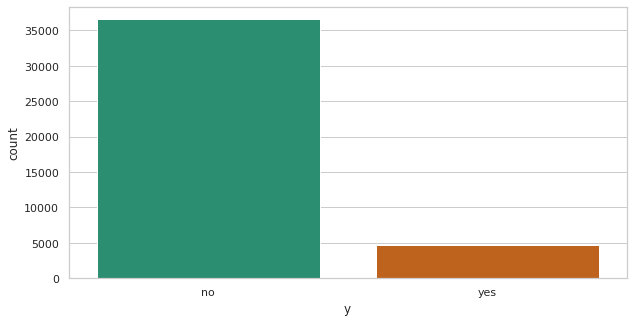

share of positive outcomes: 11.3%


In [ ]:
fig = plt.figure(figsize=(10,5))
sns.countplot(x="y", data=data)
plt.show()
print(f"share of positive outcomes: {len(data.loc[data['y']=='yes', 'y'])/len(data['y'])*100:0.03}%")

Now let's check distributions of numerical features.

In [ ]:
num_cols = ["age", "duration", "campaign", "previous", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed", "y", "bin_y"] # 
cat_cols = ["job", "marital", "education", "default", 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', "pdays", "y", "bin_y"]

# Numerical features analysis

In [ ]:
data.loc[:, "bin_y"] = data.loc[:, "y"].apply(lambda x: 0 if x == "no" else 1)
client_info = data.loc[:, num_cols[:4] + ["y", "bin_y"]].copy()
env_info = data.loc[:, num_cols[4:]].copy()

## Client and campaign info

Let's start the analysis by drawing the distribution of objects.

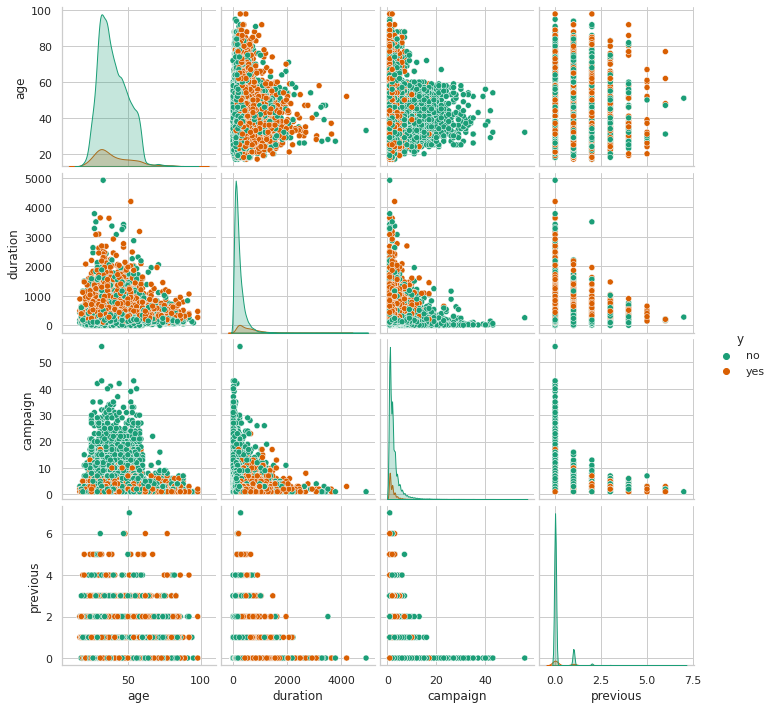

In [ ]:
sns.pairplot(client_info.iloc[:, :-1], hue="y")

So, we see that the distributions of the variables are strongly skewed due to the extreme values that some features take.
  
We start a more detailed analysis with the age variable. Let's assume that it will be possible to normalize the distribution of this variable using the box-cox transformations.

Box-Cox transformations aim to normalize variables. These transformations are an alternative to the typical transformations, such as square root transformations, log transformations, and inverse transformations. The main advantage of Box-Cox transformations is that they optimally normalize the chosen variable. Thus, they avoid the need to randomly try different transformations and automatize the data transformation process.

### Age  

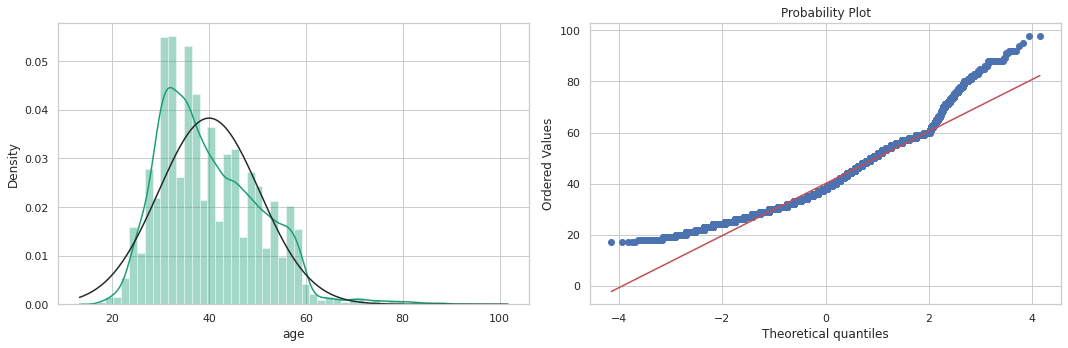

Skewness: 0.784697
Kurtosis: 0.791312 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 3904.8876514999647
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


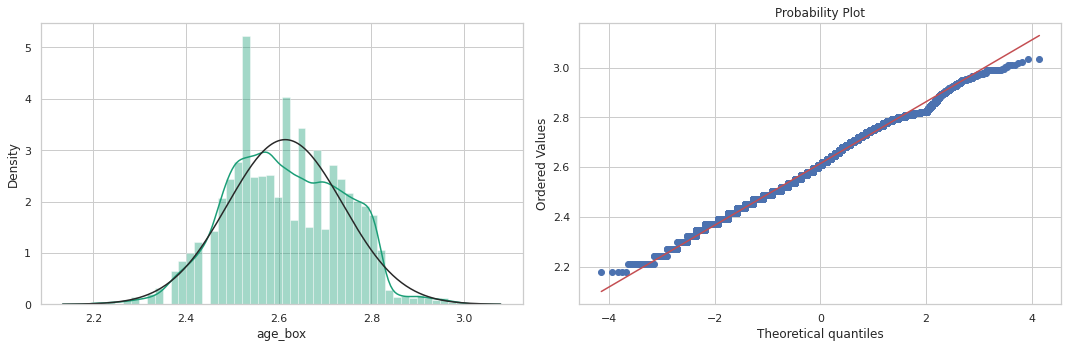

Skewness: 0.006411
Kurtosis: -0.384563 

null hypothesis: x comes from a normal distribution
p_value = 1.0218581837130634e-86, 396.0013905576502
The null hypothesis still can be rejected
But we did our best


In [ ]:
client_info.loc[:, "age"], lmbda_age = dist_graph(data=client_info.loc[:, ["age"]], target_col='age')

In [ ]:
sample1 = client_info.loc[client_info["y"] == "yes", "age"].values
sample2 = client_info.loc[client_info["y"] == "no", "age"].values

Критерий Стьюдента:

$H_0\colon$ The average age is the same for people who answered yes / no.

$H_1\colon$ not the same.

In [ ]:
# Not enough obs to reject  Ho
scipy.stats.ttest_ind(sample1, sample2, equal_var = True)

Ttest_indResult(statistic=-0.49412615149355993, pvalue=0.6212197251152586)

### Duaration

*NOTE! Cheating variable, if we know the duration it means that we know the result of the conversation too*.  
  
Probably, the length of the conversation is positively correlated with the likelihood of accepting the bank's offer

Here we got postitive Skewness too, our boxcox_transform function is ready

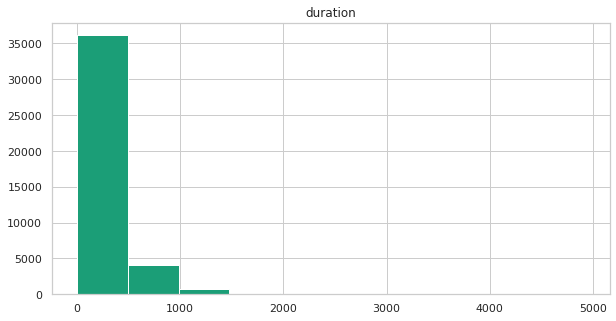

In [ ]:
client_info.loc[:, ["duration"]].hist(figsize=(10,5))
plt.show()

In [ ]:
client_info.loc[client_info["duration"]==0, "duration"].count()

4

Here we encounter a small problem. Zero values don't allow us to do log transformations. So, we'll do a log transformation to all the non-zero observations. it's only four zero values. We can ignore them all without any consequences.

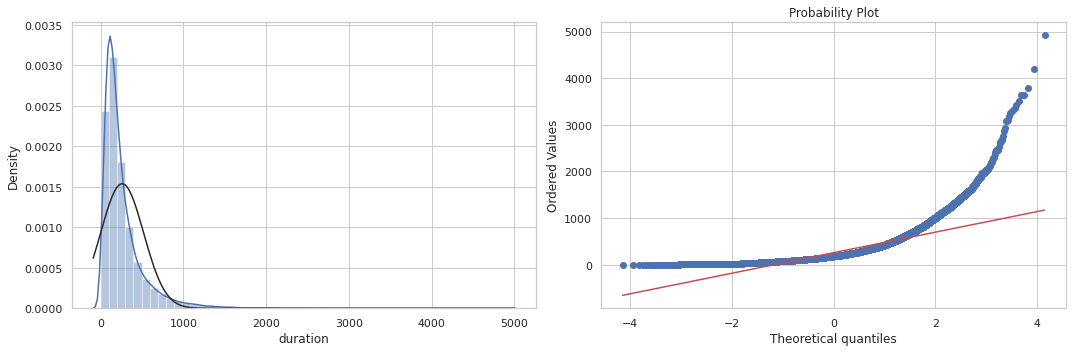

Skewness: 3.263260
Kurtosis: 20.248803 

null hypothesis: x comes from a normal distribution
p_value = 0.0, 30132.540619402876
The null hypothesis can be rejected
Oops, We shoukd try to transform the distribution!


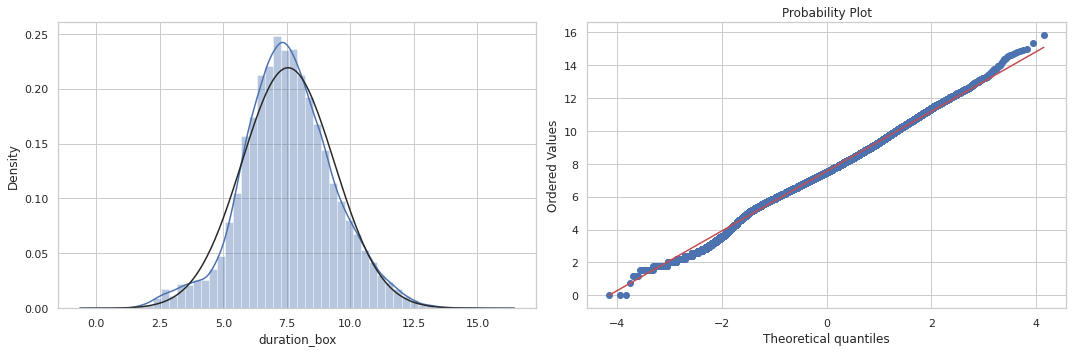

Skewness: 0.019101
Kurtosis: 0.451030 

null hypothesis: x comes from a normal distribution
p_value = 1.815889000070701e-52, 238.27569936137692
The null hypothesis still can be rejected
But we did our best


In [ ]:
client_info.loc[client_info['duration']>0, 'duration'], lmbda_dur = dist_graph(data=client_info.loc[client_info['duration']>0,['duration']].copy(), target_col='duration')

In [ ]:
sample1 = client_info.loc[client_info["y"] == "yes", "duration"].values
sample2 = client_info.loc[client_info["y"] == "no", "duration"].values

Критерий Стьюдента:

$H_0\colon$ Average duration is the same for people who answered yes / no.

$H_1\colon$ not the same.

In [ ]:
# Ho hypothesis is rejected!
scipy.stats.ttest_ind(sample1, sample2, equal_var = True)

Ttest_indResult(statistic=80.68552390721649, pvalue=0.0)

Excellent result, let's move on!

### Previous

Let's try to understand what we are dealing with

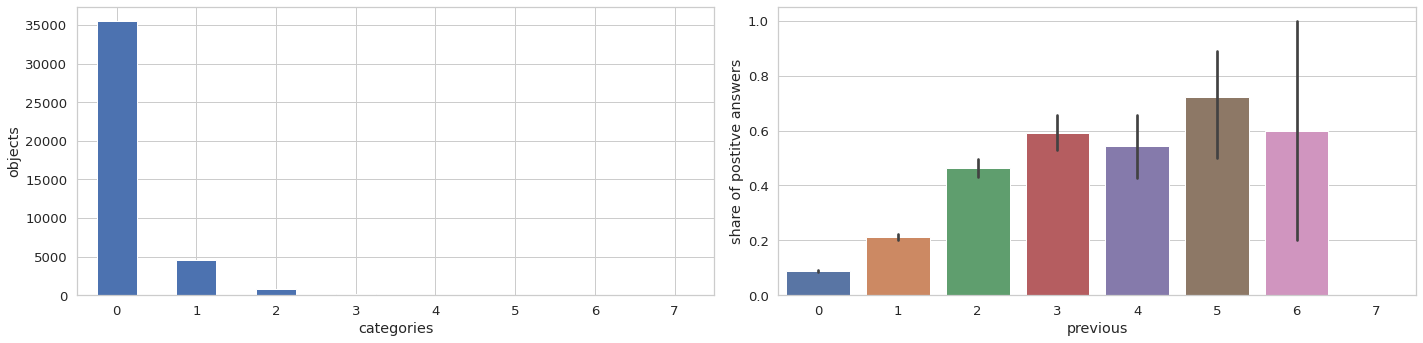

In [ ]:
plot_func(data=client_info, column_x="previous", column_y="bin_y")

Here we are dealing with the ordinal nature of the data. The main problem is that we haven't got enough observations for categories more than three. It is not good. We can make the following transformation: all values that are over three are equated to three. 
Since we can't reject the hypothesis about the equality of positive outcomes proportion in categories over 3, we can expect that this operation will not spoil the data.

In [ ]:
client_info.loc[client_info["previous"]>3, "previous"] = 3

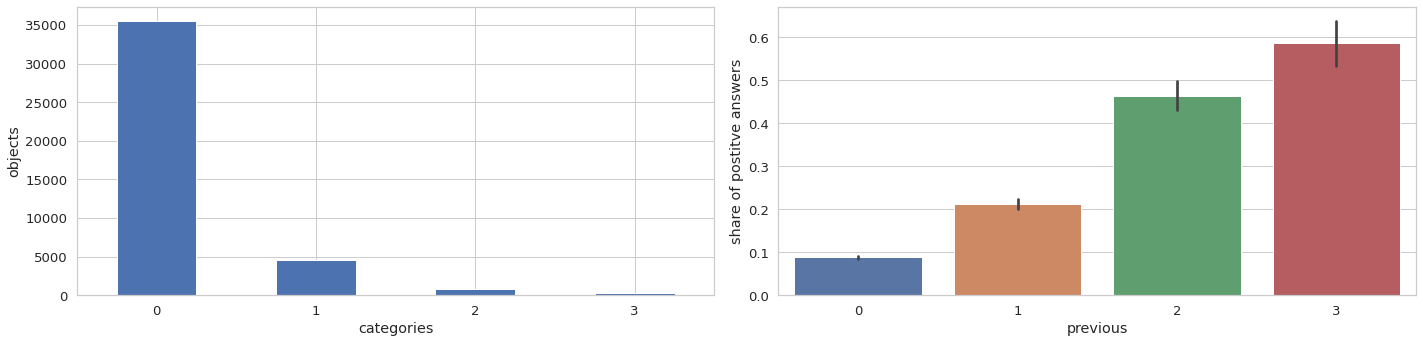

In [ ]:
plot_func(data=client_info, column_x="previous", column_y="bin_y")

There is still a wild imbalance in the categories, and maybe we should combine other categories too, but I dont think so

### Campaign

Let's transform the variable campaign in the same way.

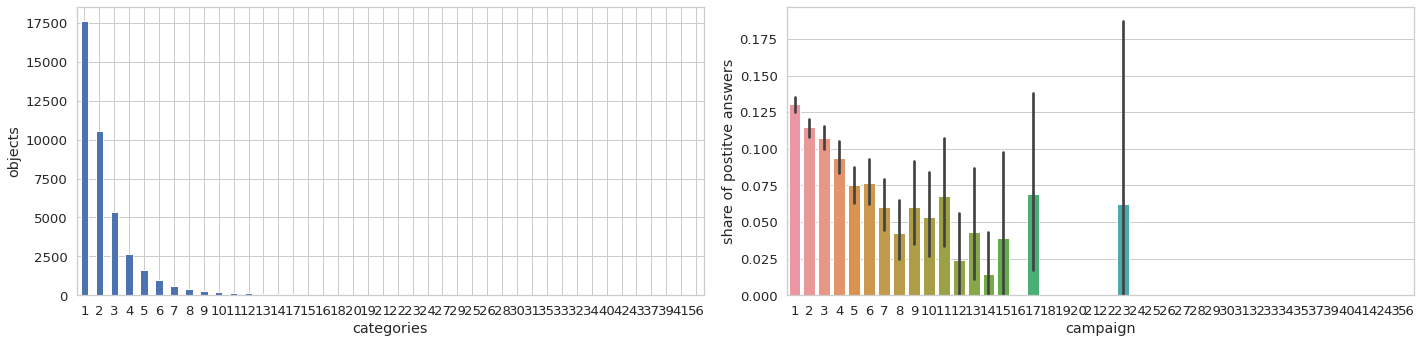

In [ ]:
plot_func(data=client_info, column_x="campaign", column_y="bin_y")

In [ ]:
client_info.loc[client_info["campaign"]>=12, "campaign"] = 12

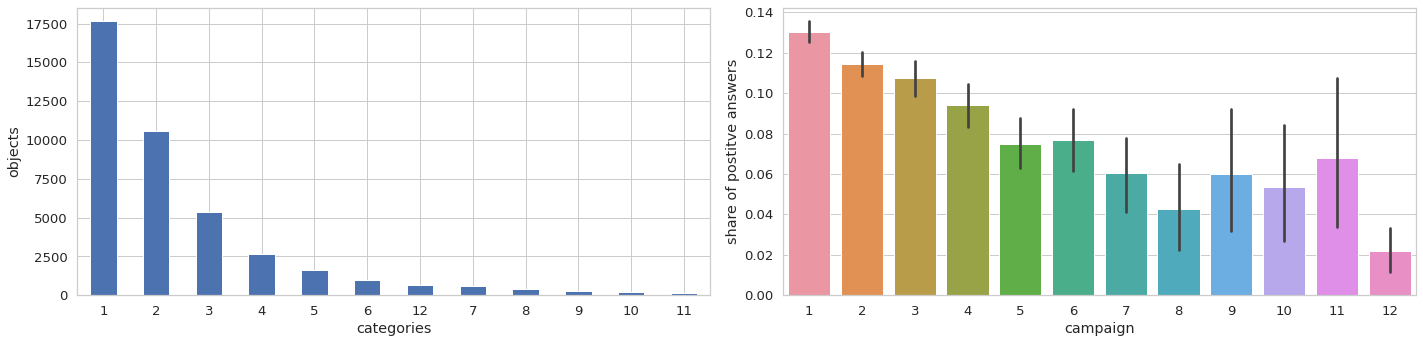

In [ ]:
plot_func(data=client_info, column_x="campaign", column_y="bin_y")

### Result

Everything seems to be much better.

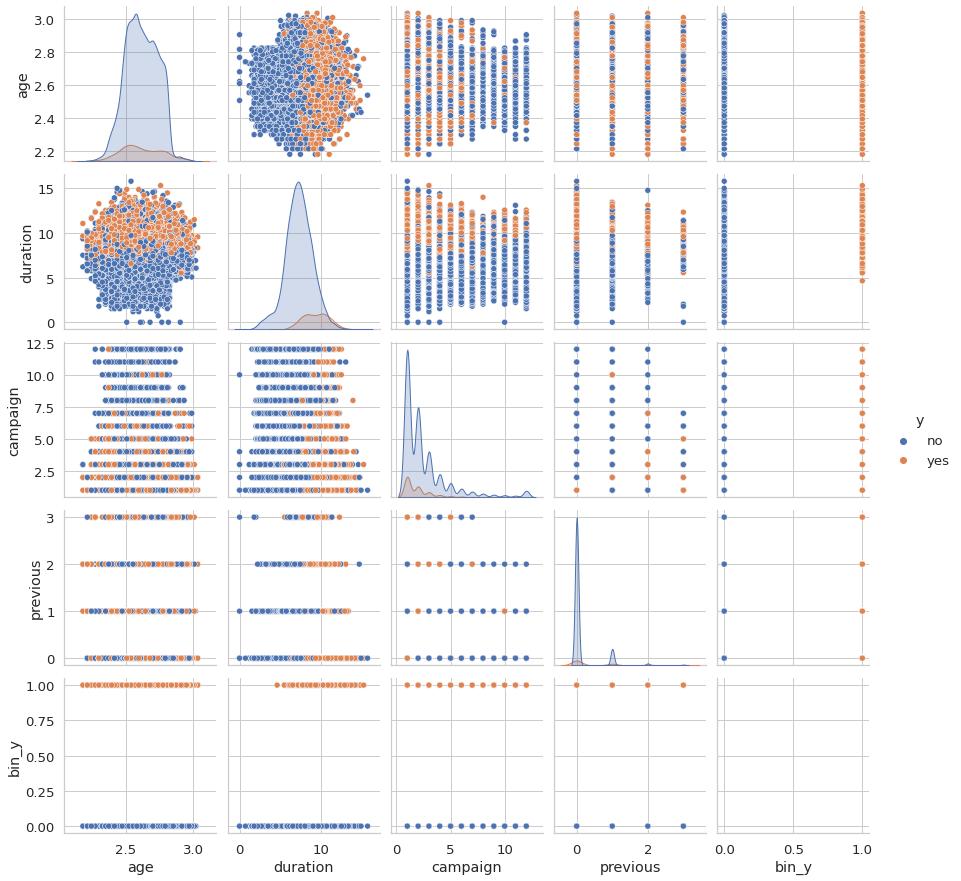

In [ ]:
sns.pairplot(client_info, hue="y")

## Macroeconomics info

So, we know that all data in the dataset is filtered by date. Observation interval: 2008 to 2010. Therefore, we can expect that the objects of our sample will be combined into clusters. Each new campaign will be characterized by its own macroeconomic situation.

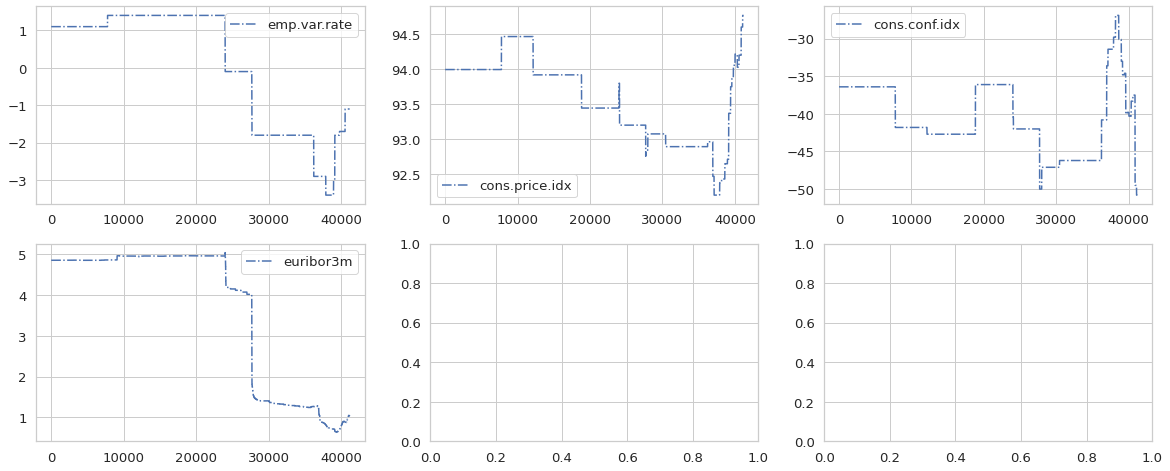

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,8))
axes = axes.ravel()
for i, column in enumerate(env_info.columns[:-2]):
    env_info.loc[:, [column]].plot(linestyle="dashdot", ax=axes[i])
plt.show()

Common sense, as well as charts, tell us that all macroeconomic indicators must be highly correlated. Let's construct a correlation matrix to make sure of this.

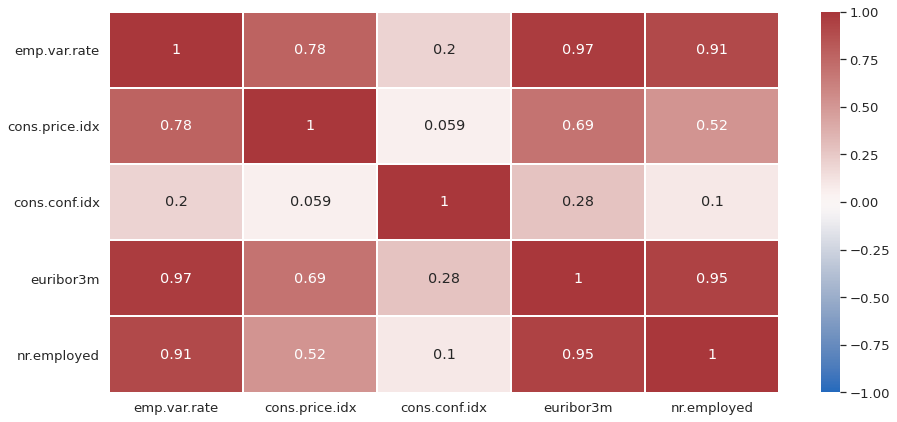

In [ ]:
corr_0 = env_info.drop(columns=["y"])
f, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr_0.corr(method='pearson'), vmin=-1, vmax=1, linewidths=0.5, cmap = 'vlag', annot=True)
plt.yticks(rotation = 0)
plt.show()

Everything is as we expected. Perhaps the only limitation that prevents the correlation from becoming even stronger is the differences in the frequency of data updates.  
  
emp.var.rate и nr.employed - quarterly updated   
cons.price.idx, cons.conf.idx - monthly updated    
euribor3m - daily updated   
  
Most likely, we are most interested in cons.conf.idx, which measures how optimistic or pessimistic consumers are regarding their expected financial situation. Interestingly, this indicator is the least correlated with the real macroeconomic situation.

Okay, let's leave only two factors for further analysis: emp.var.rate and cons.conf.idx. Next, let us transform these continuous type factors into categorical variables, dividing their values into 4 clusters.

### emp.var.rate

In [ ]:
est_1 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
est_1.fit(env_info.loc[:, ['emp.var.rate']])
bin_edges = np.round(est_1.bin_edges_[0], 2)
print(f"интервалы разбития: {np.round(est_1.bin_edges_[0], 2)}")
env_info.loc[:, ['emp.var.rate.ordinal']] = est_1.transform(env_info.loc[:, ['emp.var.rate']])

интервалы разбития: [-3.4  -2.42 -0.93  0.6   1.4 ]


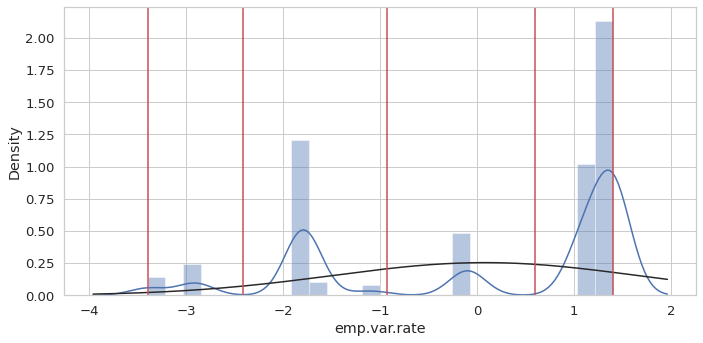

In [ ]:
fig = plt.figure(figsize=(10,5))
#histogram and normal probability plot
sns.distplot(data.loc[:, 'emp.var.rate'], fit=norm);
for edge in bin_edges:
    plt.axvline(x=edge, color = "r")
plt.tight_layout()
plt.show()

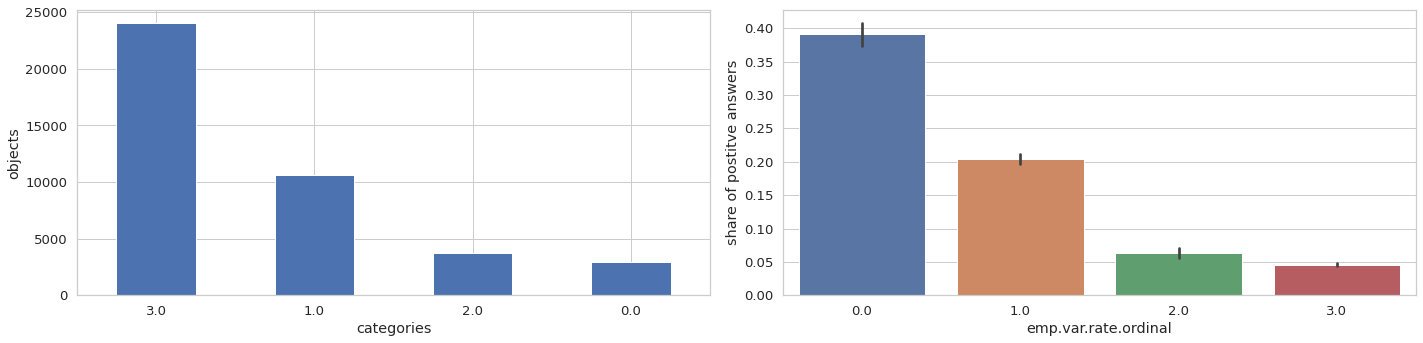

In [ ]:
plot_func(data=env_info, column_x="emp.var.rate.ordinal", column_y="bin_y")

### cons.conf.idx

In [ ]:
est_1 = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans')
est_1.fit(env_info.loc[:, ['cons.conf.idx']])
bin_edges = np.round(est_1.bin_edges_[0], 2)
print(f"интервалы разбития: {np.round(est_1.bin_edges_[0], 2)}")
env_info.loc[:, ['cons.conf.idx.ordinal']] = est_1.transform(env_info.loc[:, ['cons.conf.idx']])

интервалы разбития: [-50.8  -44.4  -39.17 -33.18 -26.9 ]


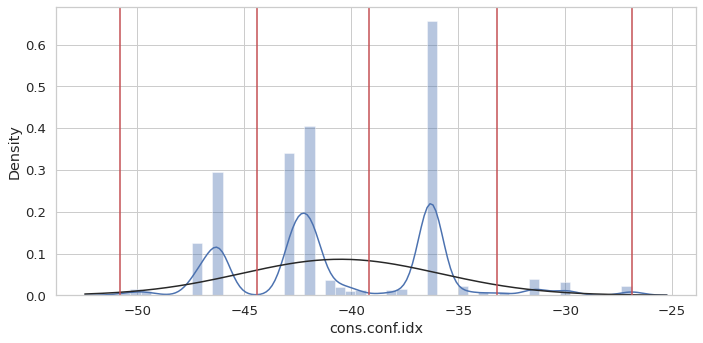

In [ ]:
fig = plt.figure(figsize=(10,5))
#histogram and normal probability plot
sns.distplot(data.loc[:, 'cons.conf.idx'], fit=norm);
for edge in bin_edges:
    plt.axvline(x=edge, color = "r")
plt.tight_layout()
plt.show()

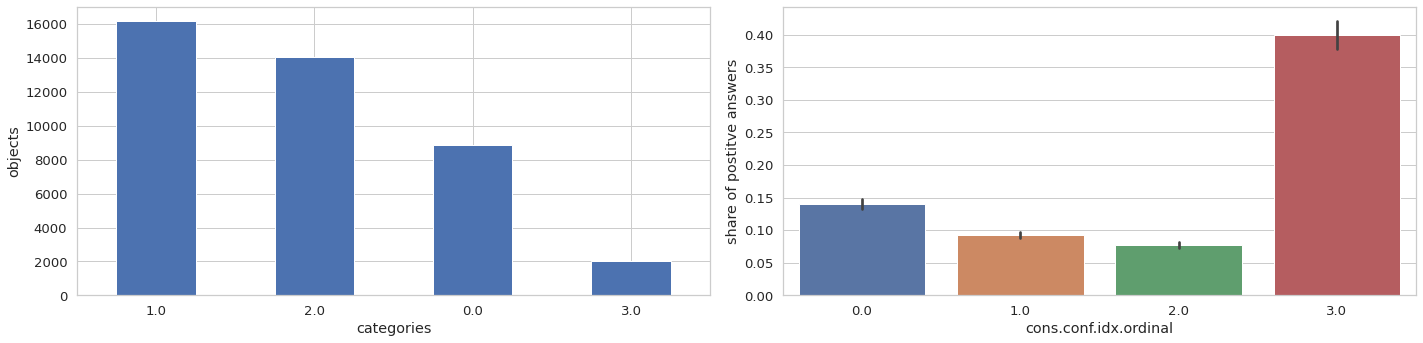

In [ ]:
plot_func(data=env_info, column_x="cons.conf.idx.ordinal", column_y="bin_y")

Well, I'm not sure if such operations are good practice.

## Conclusions

1. **Age** и **Duration**  
    BoxCox transformation 
    Preprocessing: StandardScaler  
    
2. **Previous** и **Campaign**   
    Merged some categories  
    Preprocessing: one-hot encoding

3. **nr.employed**, **cons.price.idx**, **euribor3m**  
    Removed from analysis due to high correlation with **emp.var.rate**  
    Preprocessing: one-hot encoding 

4. **cons.conf.idx** и **emp.var.rate**  
    Allocated clusters  
    Preprocessing: one-hot encoding  

# Categorical features analysis

Let's start the analysis by drawing the distribution of objects by category.

In [ ]:
data_cat = data.loc[:, cat_cols].copy()

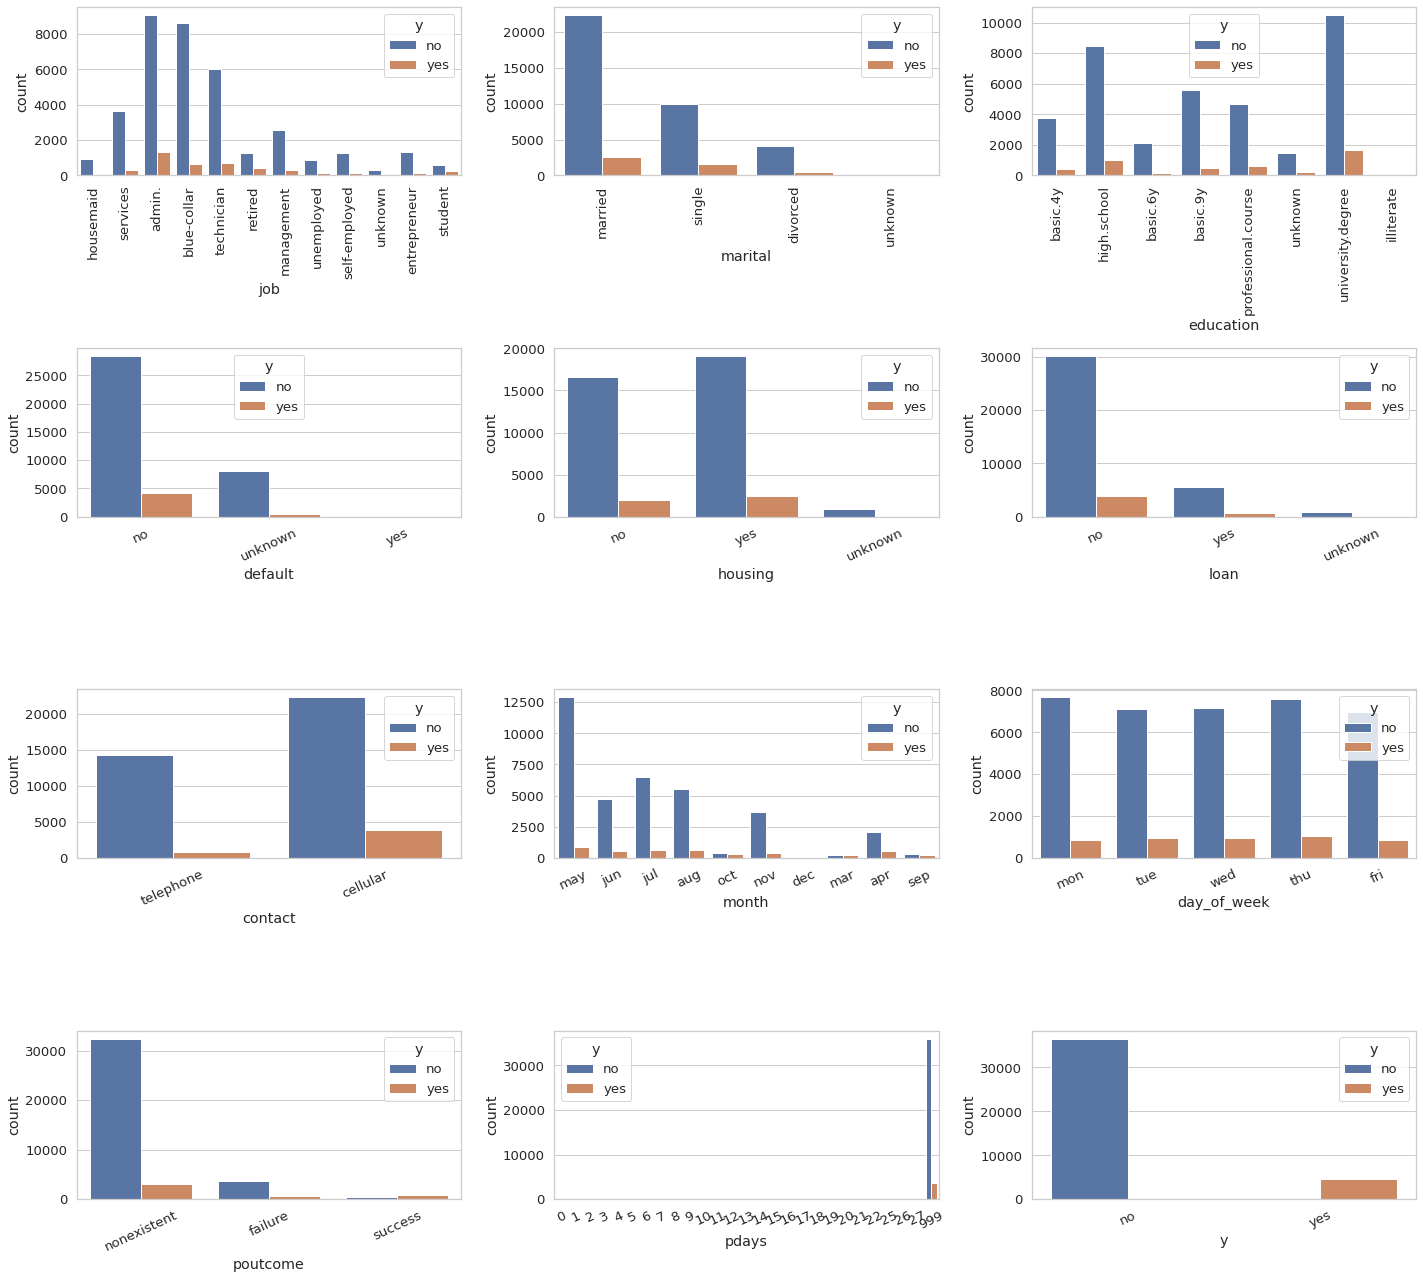

In [ ]:
# Распрделение категориальных фич
fig, axes = plt.subplots(4, 3, figsize=(20,18))
axes = axes.ravel()
for i, column in enumerate(cat_cols[:-1]):
    sns.countplot(x=column, hue='y', data=data, ax=axes[i])
    if i in [0,1,2]:
        axes[i].tick_params(axis='x', labelrotation=90)
    else:
        axes[i].tick_params(axis='x', labelrotation=25)
plt.tight_layout()
plt.show()

### pdays

In [ ]:
data.loc[:, "pdays"].value_counts()

999    39297
3        431
6        404
4        116
9         64
7         60
2         59
12        58
10        52
5         46
13        35
11        27
1         25
15        24
14        20
8         17
0         15
16        10
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

First of all, let's look at the pdays feature. The statistic of the feature is strange. "Pdays" stays for the number of days that passed by after the client was last contacted from a previous campaign. Some feature values were encoded with the value 999. 999 means the client was not previously contacted. Let's estimate the share of these values.

In [ ]:
share = len(data.loc[data["pdays"]!=999, "pdays"])/len(data.loc[data["pdays"]==999, "pdays"])
print(f"share of 999 is {(100-share*100):0.03} %")

share of 999 is 96.2 %


More than 96% of the respondents had not previously participated in the bank's campaign. Next, we need to verify the reliability of the data obtained. Let's compare the values of the pdays feature with the previous and poutcome features. If the pdays is equal to 999, this means that the previous value should be equal to 0, and the poutcome value should be nonexistent.

In [ ]:
data.loc[data["pdays"]==999, ["previous"]].value_counts()

previous
0           35563
1            3696
2             349
3              50
4              12
5               2
6               1
dtype: int64

In [ ]:
data.loc[data["pdays"]==999, ["poutcome"]].value_counts()

poutcome   
nonexistent    35563
failure         4110
dtype: int64

Okay, we got extremely strange results, logic tells us that if a person has not been contacted before the current campaign, it is very strange to expect that he participated in previous campaigns. But the data does not support the logic. 9% of people who have not been contacted before have participated in campaigns before. It makes sense to remove pdays from the analysis because of its unreliability.

### job

Common sense tells us that a person's profession significantly affects his behavior and habits. Therefore, we can expect that a person's occupation also significantly affects his desire and ability to use banking products.

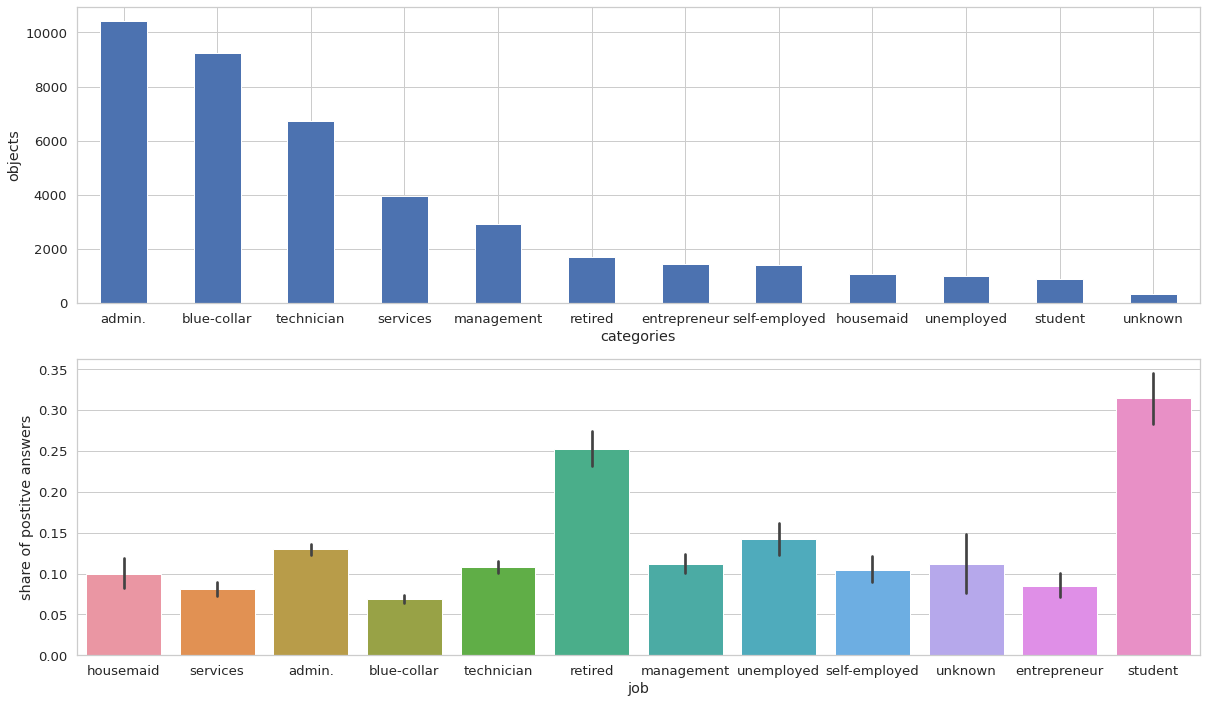

In [ ]:
sns.set(font_scale=1.2, style="whitegrid")  
fig, axes = plt.subplots(2,1,figsize=(17,10))
data_cat.loc[:, 'job'].value_counts().plot.bar(ax=axes[0])
sns.barplot(x='job', y='bin_y', data=data_cat.loc[:, ['job', 'bin_y']], ax=axes[1])
axes[0].set_xlabel("categories")
axes[0].set_ylabel("objects")
axes[0].tick_params(axis='x', labelrotation=0)
axes[1].tick_params(axis='x', labelrotation=0)
axes[1].set_ylabel("share of postitve answers")
plt.tight_layout()
plt.show()

### marital

Probably, married people are more concerned about their future and the future of their children. We assume that having a spouse is positively correlated with the target variable.

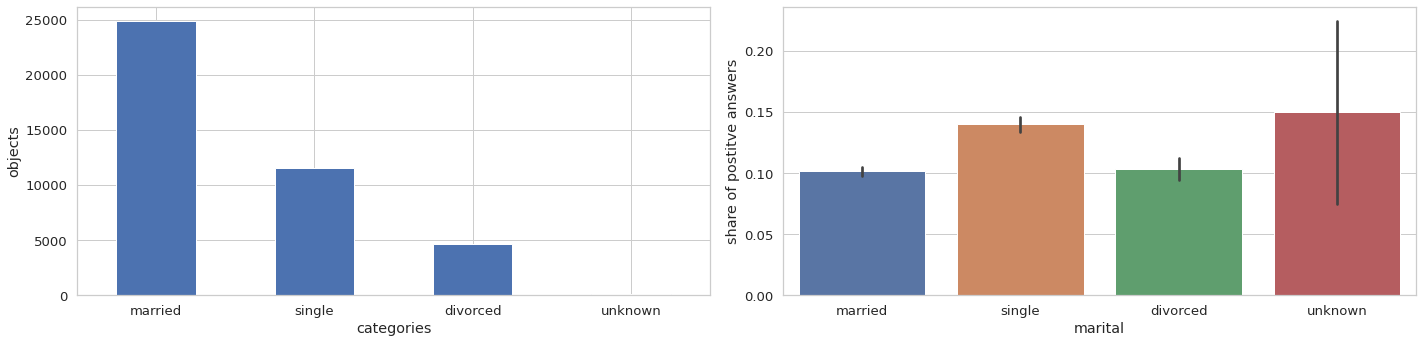

In [ ]:
plot_func(data=data_cat, column_x="marital", column_y="bin_y")

But we can see the opposite results. Maybe, it's because family is an expensive thing and people do not have enough money for deposits :D

### education

Probably, more educated people are more likely to use deposits.

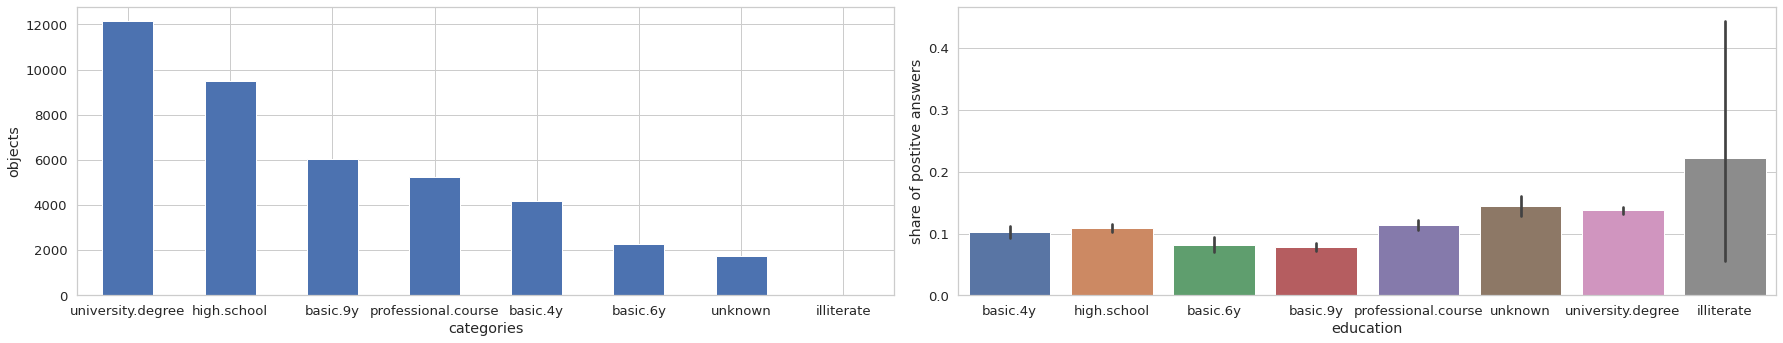

In [ ]:
plot_func(data=data_cat, column_x="education", column_y="bin_y", figsize=(25,5))

There are no enough obs. in illiterate cat. We can try to combine it with basic.4y

In [ ]:
data_cat.loc[data_cat["education"]=="illiterate","education"] = "basic.4y"

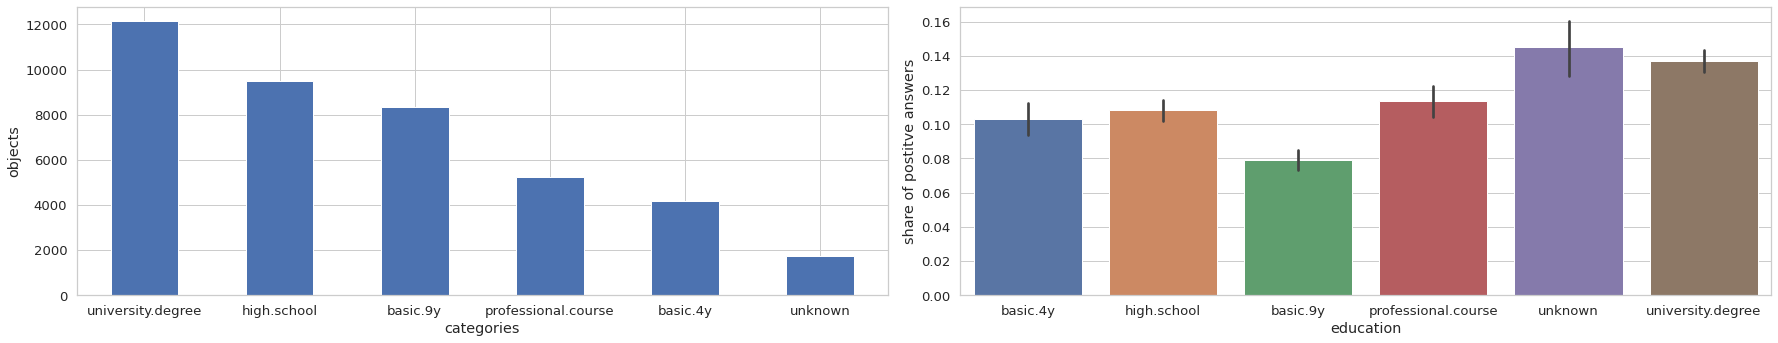

In [ ]:
plot_func(data=data_cat, column_x="education", column_y="bin_y", figsize=(25,5))

Okay, seems good

### default

If a person has credit in default, likely, he will not agree to the bank's offer.

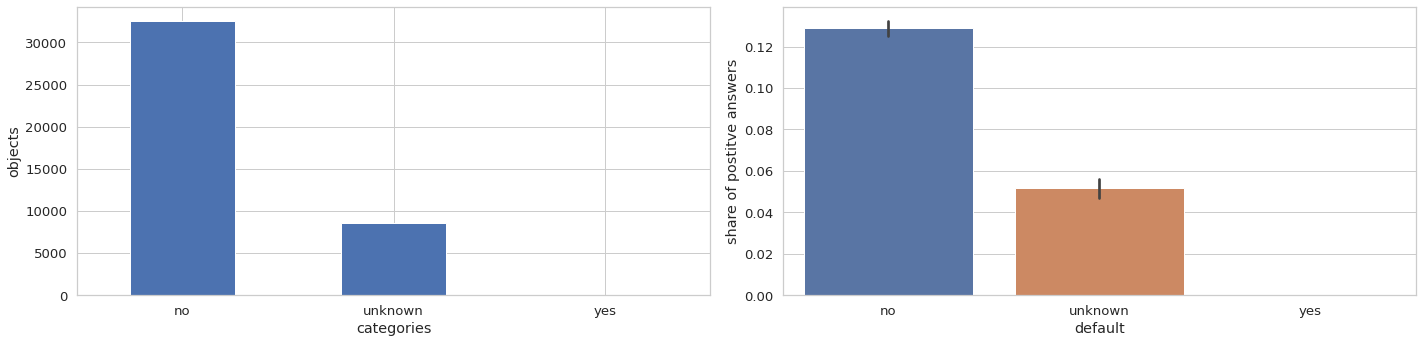

In [ ]:
plot_func(data=data_cat, column_x="default", column_y="bin_y")

In [ ]:
len(data_cat.loc[data_cat["default"]=="yes", "default"])

3

There are only three objects that have credit card default. So we should combine "Yes" category with "NAN" category.

In [ ]:
data_cat.loc[data_cat["default"]=="yes", "default"] = "unknown"

In [ ]:
contingency_table = pd.crosstab(data_cat.loc[:, "default"], data_cat.loc[:, "bin_y"])
matthews_cc(contingency_table)

MCC = -0.09934448817772791 
 Chi_square = 406.4978541213669 
 p_value = 0.0


###housing and loan

Many people take out mortgages. I am not sure if this factor will be informative. However, the presence of a mortgage indicates that a person trusts the banking system.

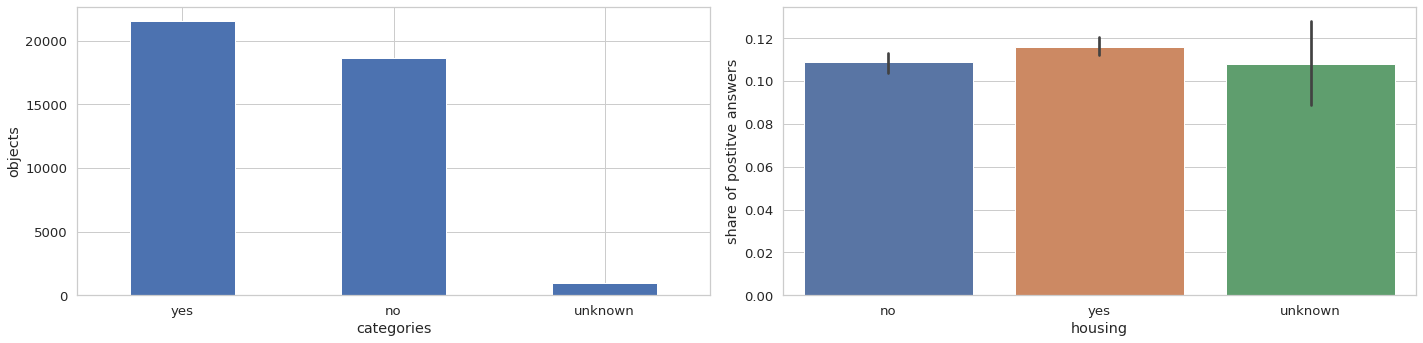

In [ ]:
plot_func(data=data_cat, column_x="housing", column_y="bin_y")

Probably, the presence of outstanding debt negatively correlated with a person's desire to open a deposit

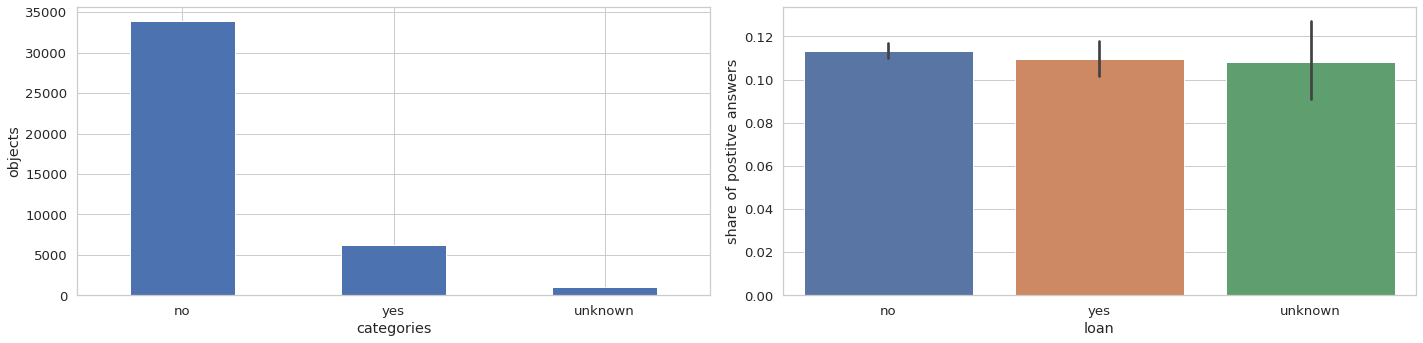

In [ ]:
plot_func(data=data_cat, column_x="loan", column_y="bin_y")

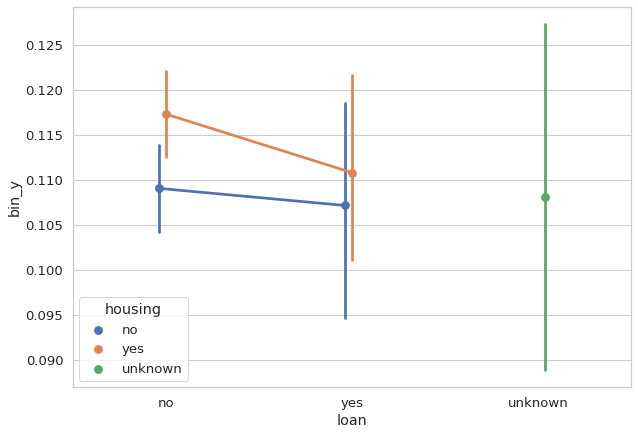

In [ ]:
fig = plt.figure(figsize=(10,7))
sns.pointplot(x="loan", y="bin_y", hue="housing", dodge=True, data=data_cat)
plt.show()

Interestingly, if the object has no debt, but has a mortgage, it is more likely to agree to the bank's proposal. Perhaps it makes sense to create an additional variable that will be equal to 1 if the object has a mortgage, but no debts, and 0 in other cases.

In [ ]:
data_cat.loc[:, "debts_intersection"] = 0 
data_cat.loc[(data_cat["housing"] == "yes") & (data_cat["loan"] == "no"), "debts_intersection"] = 1

In [ ]:
print(sum(data_cat.loc[data_cat["debts_intersection"]==1, "bin_y"]) / len(data_cat.loc[data_cat["debts_intersection"]==1, "bin_y"]) - \
sum(data_cat.loc[data_cat["debts_intersection"]==0, "bin_y"]) / len(data_cat.loc[data_cat["debts_intersection"]==0, "bin_y"]))

print(sum(data_cat.loc[data_cat["housing"]=="yes", "bin_y"]) / len(data_cat.loc[data_cat["housing"]=="yes", "bin_y"]) - \
sum(data_cat.loc[data_cat["housing"]!="yes", "bin_y"]) / len(data_cat.loc[data_cat["housing"]!="yes", "bin_y"]))

0.008220336983227758
0.007433976277340659


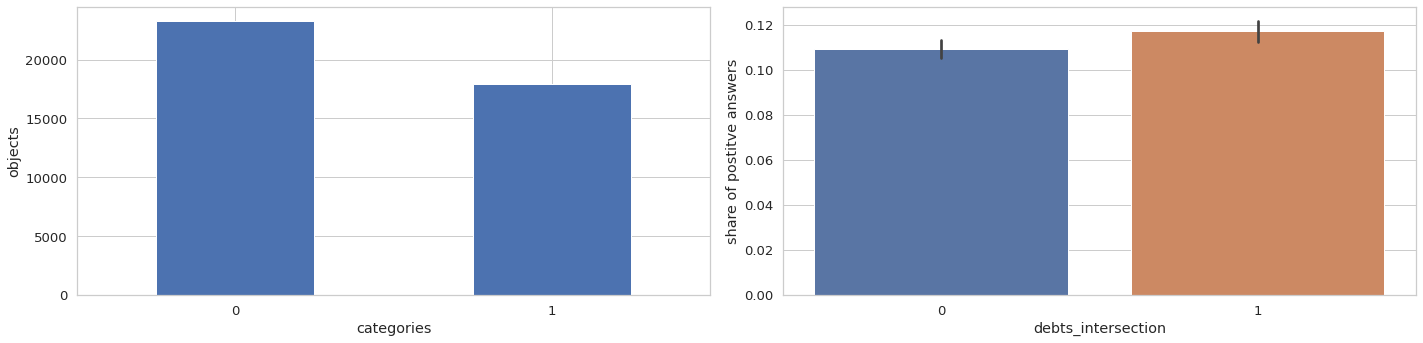

In [ ]:
plot_func(data=data_cat, column_x="debts_intersection", column_y="bin_y")

It seems like it's pretty useless feature

### contact

I consider that the object who is at home is more relaxed and ready to talk. Therefore, it is more likely to accept the bank offer.

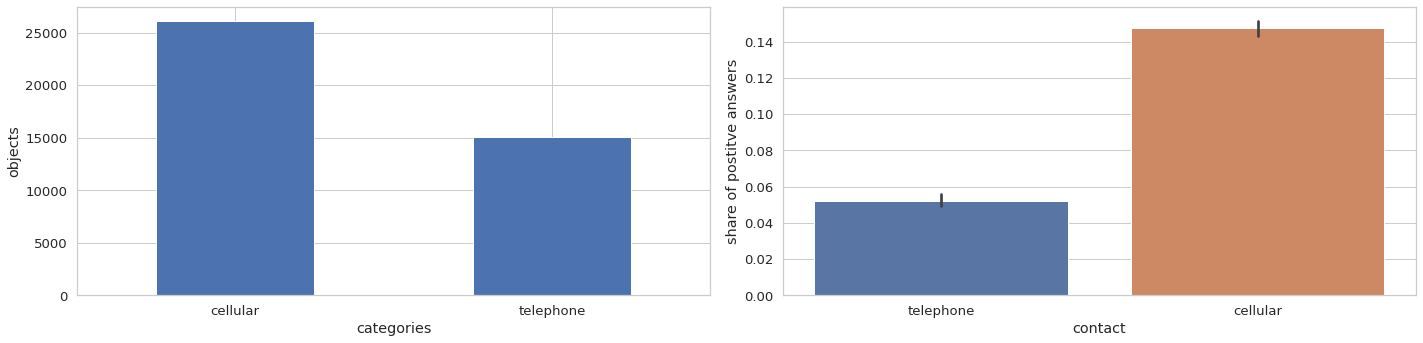

In [ ]:
plot_func(data=data_cat, column_x="contact", column_y="bin_y")

### month

Probably, time of year can significantly influence to person's mind. So we can combine months to seasons. Maybe, when it's sunny outside, people are more likely to want to accept the bank's offer. But on the other hand,  summer is a time of vacation. So that means that people are ready to spend their money or already have spent it. And therefore, they do not need to open a deposit.

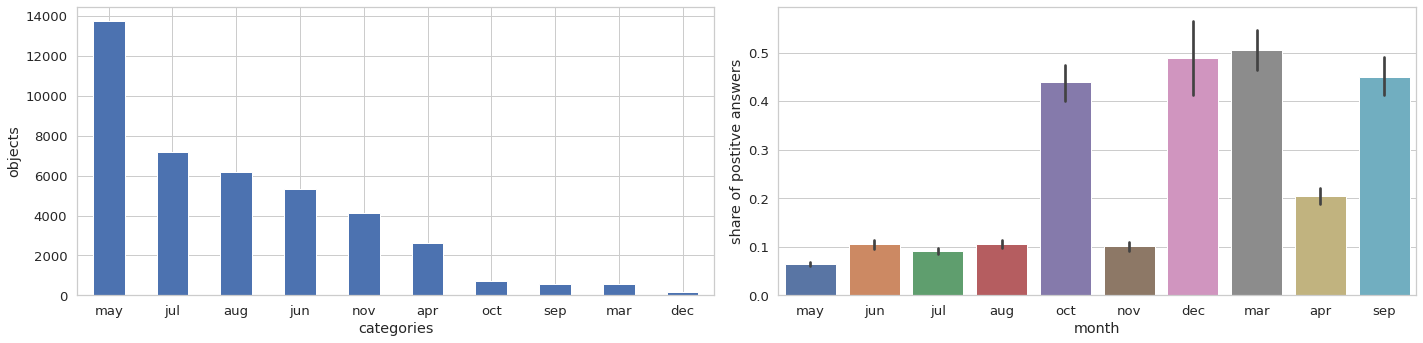

In [ ]:
plot_func(data=data_cat, column_x="month", column_y="bin_y")

In [ ]:
data_cat.loc[:, "season"] = "spring"
data_cat.loc[data_cat["month"].isin(["jun", "jul", "aug"]), "season"] = "summer"
data_cat.loc[data_cat["month"].isin(["sep", "oct", "nov"]), "season"] = "autumn"
data_cat.loc[data_cat["month"].isin(["dec", "jan", "feb"]), "season"] = "winter"

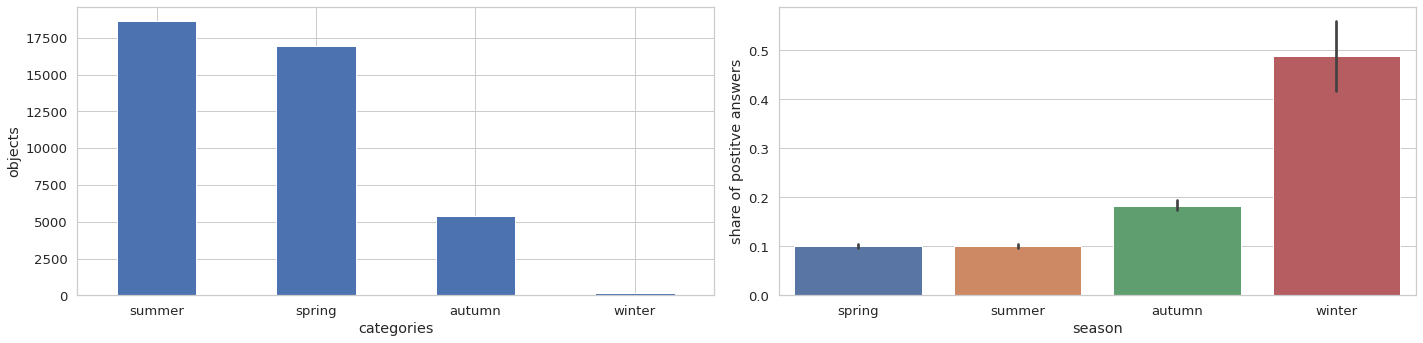

In [ ]:
plot_func(data=data_cat, column_x="season", column_y="bin_y")

There are not enough observations in wintertime. So we should combine the autumn and winter seasons into one category.

In [ ]:
data_cat.loc[data_cat["season"].isin(["autumn", "winter"]), "season"] = "cold_period"

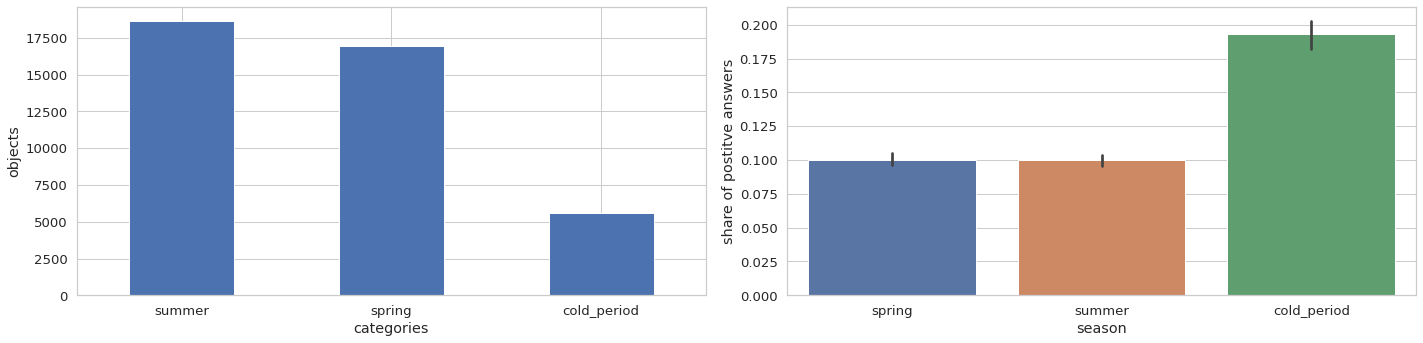

In [ ]:
plot_func(data=data_cat, column_x="season", column_y="bin_y")

Seems better, but there are no differences between summertime and springtime. Maybe a significant difference between the cold period and the warm period is just a consequence of a lack of observations. Nevertheless, we can combine summer and spring to one category in order to reduce data dimension

In [ ]:
data_cat.loc[data_cat["season"].isin(["spring", "summer"]), "season"] = "warm_period"

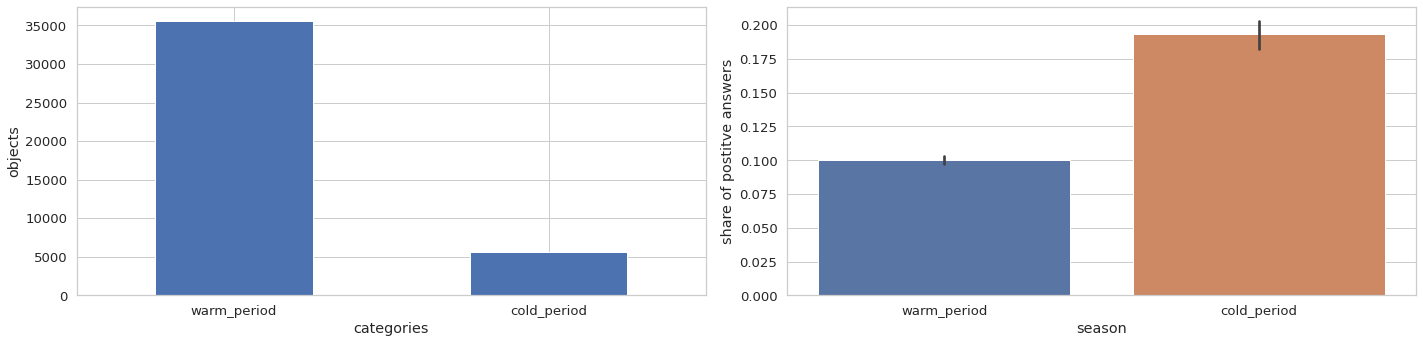

In [ ]:
plot_func(data=data_cat, column_x="season", column_y="bin_y")

### day

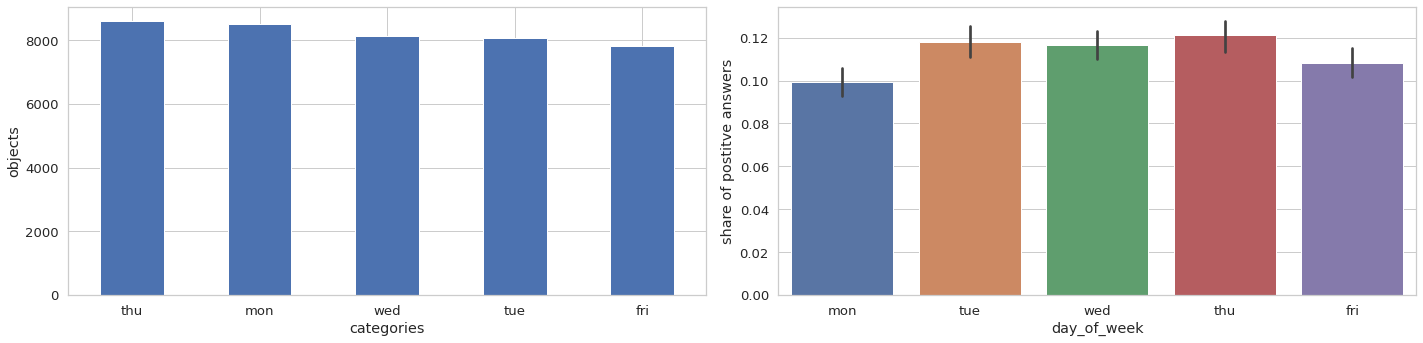

In [ ]:
plot_func(data=data_cat, column_x="day_of_week", column_y="bin_y")

Despite the fact that Wednesday is a small Friday, I do not think that the day of the week can affect a person's decision. Perhaps Monday and Friday are special days, but the rest of the days can be combined into one box

In [ ]:
data_cat.loc[data_cat["day_of_week"].isin(["tue", "wed", "thu"]), "day_of_week"] = "middle_day"

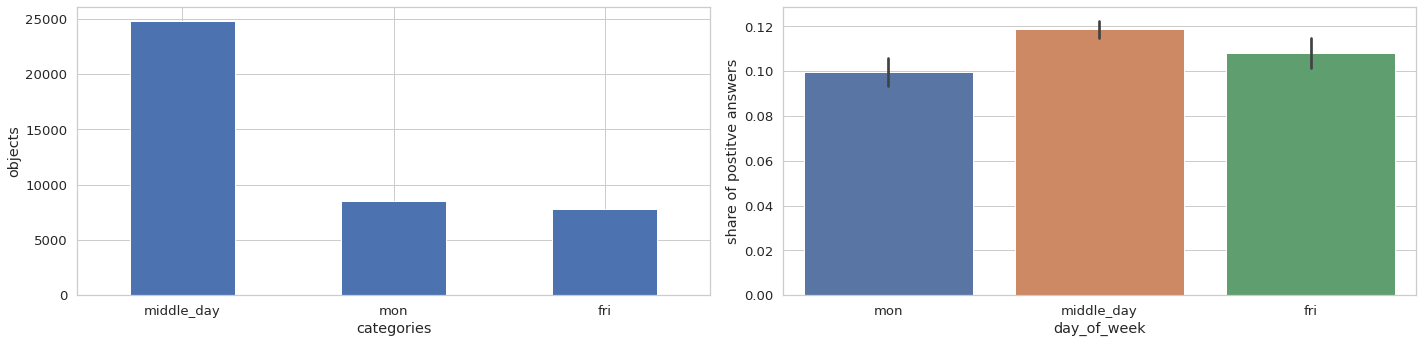

In [ ]:
plot_func(data=data_cat, column_x="day_of_week", column_y="bin_y")

That's better

### poutcome

Just a useful feature. Like an autoregressive component. People who accept the proposal in the previous campaign tend to accept the proposal in the current campaign

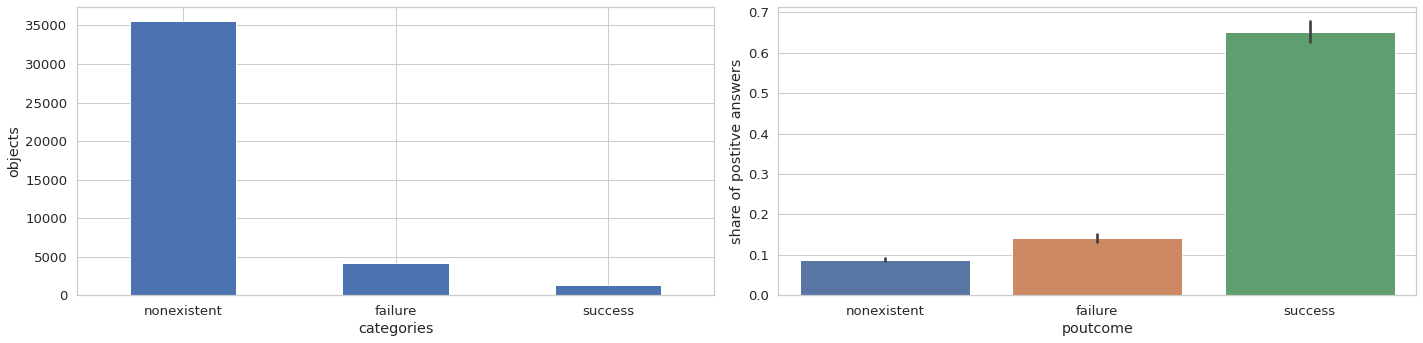

In [ ]:
plot_func(data=data_cat, column_x="poutcome", column_y="bin_y")

###  Conclusions

1. **job**  
    Preprocseeding: Target encoder

2. **marital**  
    Preprocseeding: one-hot encoding

3. **education**  
    Merged categories basic.6y и basic.9y  
    Merged categories illiterate и basic.3y  
    Preprocessing: one-hot encoding

4. **default**  
    Merged categories yes и NAN
    Preprocessing: one-hot encoding

5. **housing and loan**  
    Created new variable **debts_intersection**  
    Preprocessing: one-hot encoding

6. **contact**  
    Preprocessing: one-hot encoding

7. **month**  
    Merged categories
    Preprocessing: one-hot encoding

8. **day**  
    Merged categories tue, wed, thu into middle_days
    Preprocessing: one-hot encoding  

9. **poutcome**
    reprocessing: one-hot encoding

# Hadle with missing values

First of all, let's handle the missing values in the data. Let's create new categories for missing values if their share is more than 1%. Otherwise, we will delete objects containing them

In [ ]:
data = data.apply(lambda x: x.apply(lambda x: np.nan if x=="unknown" else x))
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
indexes = missing_data.loc[missing_data.Percent > .01].index.values
missing_data.loc[missing_data.Total > 0]

,Total,Percent
default,8597,0.208726
education,1731,0.042027
housing,990,0.024036
loan,990,0.024036
job,330,0.008012
marital,80,0.001942


Missed values in such features as housing and loan are overlapped.  
But I haven't figured out what does it mean.
So we can use them as a separate category

In [ ]:
len(data.loc[(data["loan"].isnull()) & (data["housing"].isnull()), :])

990

In [ ]:
for index in indexes:
    data.loc[data[index].isnull(), index] = "NaN"
before = data.shape[0]
data.dropna(inplace=True)
after = data.shape[0]
print(f"Percentage of deleted objects  {((before-after)/before)*100: 0.03} %")

Percentage of deleted objects   0.974 %


# Pipeline

In [ ]:
data = pd.read_csv("/content/bank-additional-full.csv", sep=';')

# create new feature
data.loc[:, "debts_intersection"] = 0 
data.loc[(data["housing"] == "yes") & (data["loan"] == "no"), "debts_intersection"] = 1

data.loc[:, "pdays"] = data.loc[:, "pdays"].apply(lambda x: 0 if x == 999 else 1)

# convert y to [0,1]
data.loc[:, "y"]=data.loc[:, "y"].apply(lambda x: 0 if x == "no" else 1)

# delete NAN
print(data.shape)
data = data.apply(lambda x: x.apply(lambda x: np.nan if x=="unknown" else x) if x.name in ["job", "marital"] else x)
data.dropna(inplace=True)
print(data.shape)

(41188, 22)
(40787, 22)


In [ ]:
x_data = data.loc[:, ["age", "duration", 'cons.conf.idx', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed',
                        "job", "previous", "campaign", "marital", "housing", "loan", "debts_intersection", "month", 
                        "day_of_week", "poutcome", "default", "contact", "education", "pdays"]]
y_data = data.loc[:, ["y"]]

# x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=123)

In [ ]:
class BCT(BaseEstimator, TransformerMixin):
    """Apply boxcox transformation"""
    def __init__(self):
        self.lmbda_dict = {}
        
    def fit(self, X, y=None):
        for column in X.columns:
            _, lmbda = stats.boxcox(X.loc[X[column]>0, column])
            self.lmbda_dict[column] = lmbda
        return self
    
    def transform(self, X):
        for i, column in enumerate(X.columns):
            X.loc[X[column]>0, column] = stats.boxcox(X.loc[X[column]>0, column],  lmbda=self.lmbda_dict[column])
        return X


class Combiner(BaseEstimator, TransformerMixin):
    """combine categories. Use it just because I can"""
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        if "previous" in X.columns:
            X.loc[X["previous"]>3, "previous"] = 3
            X.loc[X["campaign"]>=12, "campaign"] = 12

        elif "default" in X.columns:
            X.loc[X["default"]=="yes", "default"] = "unknown"


        elif "education" in X.columns:
            X.loc[X["education"]=="illiterate","education"] = "basic.4y"

        elif "month" in X.columns:
            X.loc[:, "season"] = "spring"
            X.loc[X["month"].isin(["jun", "jul", "aug"]), "season"] = "summer"
            X.loc[X["month"].isin(["sep", "oct", "nov"]), "season"] = "autumn"
            X.loc[X["month"].isin(["dec", "jan", "feb"]), "season"] = "winter"
            X.loc[X["season"].isin(["autumn", "winter"]), "season"] = "cold_period"
            X.loc[X["season"].isin(["spring", "summer"]), "season"] = "warm_period"
            X.drop(columns=["month"], inplace=True)
            
            X.loc[X["day_of_week"].isin(["tue", "wed", "thu"]), "day_of_week"] = "middle_day"

        return X


class BinsDiscretizer(BaseEstimator, TransformerMixin):
    """transform cont to categorical, only for current time period"""
    def __init__(self):
        self.bin_edges = {"emp.var.rate": [-3.4, -2.42, -0.93, 0.6, 1.4],
                          "cons.conf.idx": [-50.8, -44.4, -39.17, -33.18, -26.9]}
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):

        X = X.drop(columns = ['cons.price.idx', 'euribor3m', 'nr.employed' ])

        for jj, column in enumerate(X.columns):
            rtol, atol = 1.e-5, 1.e-8
            eps = atol + rtol * np.abs(X.iloc[:, jj])
            X.iloc[:, jj] =class Combiner(BaseEstimator, TransformerMixin):
            X.iloc[:, jj] = np.clip(X.iloc[:, jj], 0, 4 - 1)
        return X

In [ ]:
columns_cont = ["age", "duration"]
columns_transform = ['cons.conf.idx', 'emp.var.rate','cons.price.idx', 'euribor3m', 'nr.employed' ]
columns_target_enc = ["job"]
columns_for_norm = ["previous", "campaign"]
columns_ohe = ["marital", "housing", "loan", "debts_intersection", "month", "day_of_week", "poutcome", "default", "contact", "pdays"]
column_ordinal = ["education"]

In [ ]:
# Определяем ЛогРег
# classifier = LogisticRegression(random_state=42, C=0.01, penalty="l2", solver="lbfgs")
# Определим SMOTE
# sm = SMOTE(random_state=123, k_neighbors=5)

cont_pipeline = Pipeline(steps=[
                                ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_cont])),
                                ('box_cox', BCT()),                            # BoxCox
                                ('scaler', StandardScaler())                   # StandardScaler
                                ])

transform_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_transform])),
                              ("bins_discretizer", BinsDiscretizer()),
                              ("ohe", OneHotEncoder(sparse=False, drop="first"))
                              ])

target_enc_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_target_enc])),
                              ("target_enc", TargetEncoder(cols=columns_target_enc, return_df=False)),
                              ("minmax", MinMaxScaler(feature_range=(0,3)))  # to interval [0,3]
                              ])

norm_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_for_norm])),
                              ('combiner', Combiner()),
                              ("minmax", MinMaxScaler(feature_range=(0,3)))  # to interval [0,3]
                              ])

ohe_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, columns_ohe])),
                              ('combiner', Combiner()),
                              ("ohe", OneHotEncoder(sparse=False, drop="first"))
                              ])

ordinal_pipeline = Pipeline(steps=[
                              ('selecting', FunctionTransformer(lambda dataset: dataset.loc[:, column_ordinal])),
                              ('combiner', Combiner()),
                              ('enc', OrdinalEncoder(categories=[['unknown','basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']])),
                              ("minmax", MinMaxScaler(feature_range=(0,3)))  # to interval [0,3]
                              ])


feature_union = FeatureUnion(transformer_list = [
                                                 ("cont_pipeline", cont_pipeline),
                                                 ("transform_pipeline", transform_pipeline),
                                                 ("target_enc_pipeline", target_enc_pipeline),
                                                 ("norm_pipe", norm_pipeline),
                                                 ("ohe_pipeline", ohe_pipeline),
                                                 ("ordinal_pipeline", ordinal_pipeline)
                                                 ]
                             )

main_pipeline = imb_make_pipeline(steps = [
                                           ('feature_processing', feature_union)
                                          ]
                                 )

# ("pca", PCA(n_components=0.95)),
# ('SMOTE', sm),
# ('model_fitting', classifier) 
# predictor = main_pipeline.fit(X=x_train.copy(), y=y_train.copy())

train = main_pipeline.fit_transform(X=x_data.copy(), y=y_data.copy())

In [ ]:
# drop outliers
print(train.shape)
print(train[np.abs(stats.zscore(train[:, 0])) < 3].shape)
train = train[np.abs(stats.zscore(train[:, 0])) < 3]

print(train.shape)
print(train[np.abs(stats.zscore(train[:, 1])) < 3].shape)
train = train[np.abs(stats.zscore(train[:, 1])) < 3]

(40555, 37)
(40512, 37)
(40512, 37)
(40493, 37)


Лучшее качество auc_best_estimator: 0.922


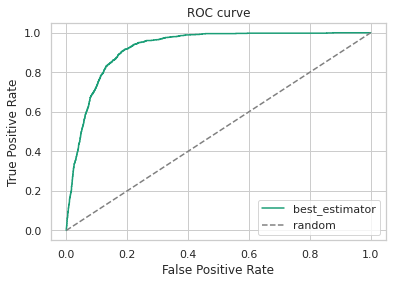

In [ ]:
# func_roc_auc(proba=predictor.predict_proba(x_test.copy()), y=y_test.copy())

# PCA

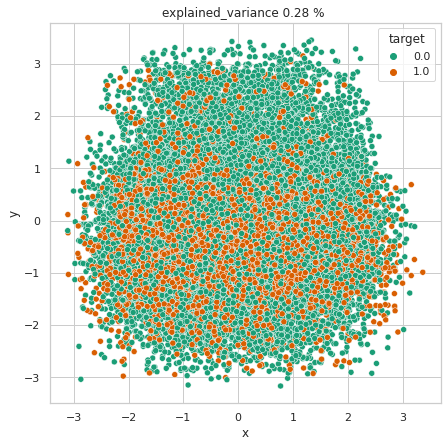

In [ ]:
# The results are poor. At least in 2D, classes are not separable :(
pca = PCA(n_components=2)
new_X = pca.fit_transform(train)

plot_df = pd.DataFrame.from_records(data=new_X,columns=["x","y"])
plot_df["target"] = data.loc[:, "y"]

fig = plt.figure(figsize=(7,7))
plt.title(f"explained_variance {pca.explained_variance_ratio_.sum():0.02} % ")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()

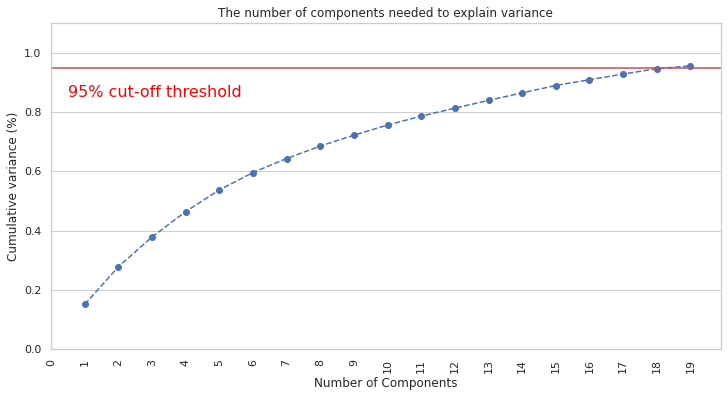

In [ ]:
pca = PCA(n_components=0.95).fit(train)

number_of_ticks = len(pca.explained_variance_ratio_) + 1

fig, ax = plt.subplots(figsize=(12, 6))
x_ticks = np.arange(1, number_of_ticks, step=1)
y_values = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(x_ticks, y_values, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, number_of_ticks, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.xticks(rotation=90)
plt.show()

# SVD

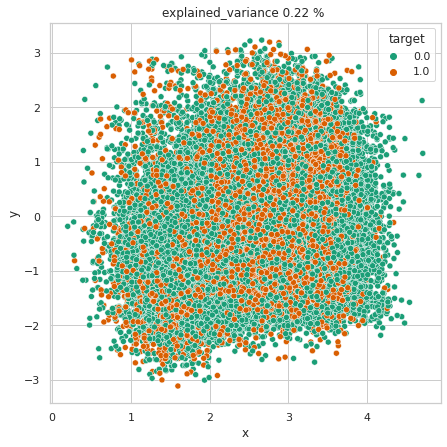

In [ ]:
# Same as PCA
svd = TruncatedSVD(n_components=2, algorithm='arpack')
svd_X = svd.fit_transform(train)

plot_df = pd.DataFrame.from_records(data=svd_X[:,:2],columns=["x","y"])
plot_df["target"] = data.loc[:, "y"]

fig = plt.figure(figsize=(7,7))
plt.title(f"explained_variance {svd.explained_variance_ratio_.sum():0.02} % ")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()


# UMAP

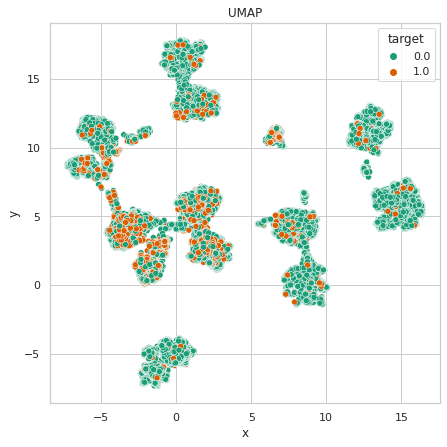

In [ ]:
embedding = umap.UMAP(n_neighbors=20, min_dist=0.15).fit_transform(train)
plot_df = pd.DataFrame.from_records(data=embedding,columns=["x","y"])
plot_df["target"] = data["y"]

fig = plt.figure(figsize=(7,7))
plt.title(f"UMAP")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()

# t-SNE

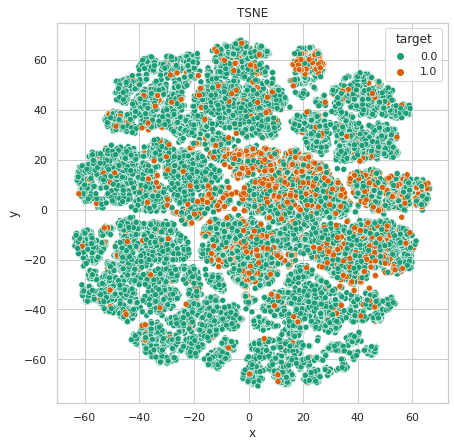

In [ ]:
tsne = TSNE()
tsne_X = tsne.fit_transform(train)

plot_df = pd.DataFrame.from_records(data=tsne_X,columns=["x","y"])
plot_df["target"] = data["y"]

fig = plt.figure(figsize=(7,7))
plt.title(f"TSNE")
sns.scatterplot("x", "y", data=plot_df, hue="target", palette="Dark2")
plt.show()